In [1]:
# !conda install -c conda-forge imbalanced-learn -y
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Conv3D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import CSVLogger
import psutil

2024-01-19 10:11:08.416096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0
2.12.0


In [2]:
def print_memory_usage():
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage percentage: {memory.percent}%")

def print_cpu_usage():
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")

In [3]:
import h5py
import gc

def load_combine_shuffle_data_optimized_hdf5():
    with h5py.File('/gpfs/slac/atlas/fs1/d/hjia625/Smart_Pixel/data.hdf5', 'r') as h5f:
        combined_input = None
        combined_target = None

        for charge_type in ['positive-charge', 'negative-charge']:
            for data_type in ['sig', 'bkg']:
                # Construct dataset names
                input_dataset_name = f'{charge_type}_{data_type}_input'
                target_dataset_name = f'{charge_type}_{data_type}_target'

                # Check if the dataset exists and load data sequentially
                if input_dataset_name in h5f and target_dataset_name in h5f:
                    input_data = h5f[input_dataset_name][:].astype(np.float16)
                    target_data = h5f[target_dataset_name][:].astype(np.float16)

                    if combined_input is None:
                        combined_input = input_data
                        combined_target = target_data
                        # Free memory of the loaded data
                        del input_data, target_data
                        gc.collect()

                    else:
                        print_memory_usage()
                        combined_input = np.vstack((combined_input, input_data))
                        combined_target = np.vstack((combined_target, target_data))
                        # Free memory of the loaded data
                        del input_data, target_data
                        gc.collect()

                else:
                    print(f"Dataset {input_dataset_name} or {target_dataset_name} not found.")

        # Shuffling
        indices = np.arange(combined_input.shape[0])
        np.random.shuffle(indices)
        combined_input = combined_input[indices]
        combined_target = combined_target[indices]

        return combined_input, combined_target

# Example usage
X, y = load_combine_shuffle_data_optimized_hdf5()

Total memory: 58.80 GB
Available memory: 39.17 GB
Used memory: 18.10 GB
Memory usage percentage: 33.4%
Total memory: 58.80 GB
Available memory: 38.05 GB
Used memory: 19.22 GB
Memory usage percentage: 35.3%
Total memory: 58.80 GB
Available memory: 36.93 GB
Used memory: 20.34 GB
Memory usage percentage: 37.2%


In [4]:
# # Initialize an empty list to store DataFrames
# combined_df1 = pd.DataFrame()
# combined_df2 = pd.DataFrame()
# number_list = list(range(16501,16520)) # + list(range(16601,16610))
# # Loop through the range of numbers
# for number in number_list:
#     print("loading ", number)
#     # Construct the file name
#     file1_pos_name = f'/gpfs/slac/atlas/fs1/d/hjia625/Smart_Pixel/positive-charge/recon8t_d{number}.csv'
#     file2_pos_name = f'/gpfs/slac/atlas/fs1/d/hjia625/Smart_Pixel/positive-charge/labels_d{number}.csv'
#     file1_neg_name = f'/gpfs/slac/atlas/fs1/d/hjia625/Smart_Pixel/negative-charge/recon8t_d{number}.csv'
#     file2_neg_name = f'/gpfs/slac/atlas/fs1/d/hjia625/Smart_Pixel/negative-charge/labels_d{number}.csv'
#     # Read the CSV file
#     df1_pos = pd.read_csv(file1_pos_name, dtype='float32')
#     df2_pos = pd.read_csv(file2_pos_name, dtype='float32')
#     df1_neg = pd.read_csv(file1_neg_name, dtype='float32')
#     df2_neg = pd.read_csv(file2_neg_name, dtype='float32')

#     # df2_pos['charge'] = 1
#     # df2_neg['charge'] = -1

#     # Concatenate all DataFrames in the list
#     combined_df1 = pd.concat([combined_df1, df1_pos, df1_neg], ignore_index=True)
#     combined_df2 = pd.concat([combined_df2, df2_pos, df2_neg], ignore_index=True)
# print_memory_usage()

In [5]:
# import gc
# print(combined_df2.describe())
# X = combined_df1.to_numpy(dtype="float32")
# y = combined_df2.to_numpy(dtype="float32")
# del combined_df1
# del combined_df2
# n = X.shape[0]
# print(X.shape, y.shape)
# gc.collect()
# print_memory_usage()

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def display(x_dataset, y_dataset, i):
    # Extract the i-th data point from both datasets
    x_data_point = x_dataset[i]
    y_data_point = y_dataset[i]

    # Check if the index is valid
    if x_data_point.shape != (8, 13, 21):
        raise ValueError("Invalid shape for the x data point")

    # Extracting the transverse momentum (pt) from the y dataset
    pt = y_data_point[8]  # Assuming the 9th variable is at index 8

    fig, ax_main = plt.subplots(figsize=(8, 6))
    divider = make_axes_locatable(ax_main)

    # Add row sum plot as an inset to the main plot
    ax_row = divider.append_axes("right", size="20%", pad=0.4)

    # Add column sum plot below the main plot
    ax_column = divider.append_axes("bottom", size="20%", pad=0.5)

    # Initial plot
    im = ax_main.imshow(x_data_point[0, :, :], cmap='plasma')
    ax_main.invert_yaxis()
    ax_main.set_yticks(np.arange(x_data_point.shape[1]))
    ax_main.set_xticks(np.arange(x_data_point.shape[2]))
    ax_main.set_xlim(0, x_data_point.shape[2]-1)
    ax_main.set_ylim(0, x_data_point.shape[1]-1)
    ax_main.grid(True, color='gray', alpha=0.7)

    # Function to update the animation
    def update(t):
        # Update main plot
        data = x_data_point[t, :, :]
        im.set_data(data)

        # Update row sum plot
        ax_row.clear()
        ax_row.barh(np.arange(data.shape[0]), np.sum(data, axis=1), color='red')
        ax_row.set_ylim(0, data.shape[0]-1)
        ax_row.set_yticks(np.arange(data.shape[0]))
        ax_row.set_xlim(np.min(x_data_point[:, :, :].sum(axis=2)) * 1.1, np.max(x_data_point[:, :, :].sum(axis=2)) * 1.1)
        ax_row.set_xlabel("Row Sum")

        # Update column sum plot
        ax_column.clear()
        ax_column.bar(np.arange(data.shape[1]), np.sum(data, axis=0), color='blue')
        ax_column.set_xlim(0, data.shape[1]-1)
        ax_column.set_xticks(np.arange(data.shape[1]))
        ax_column.set_ylim(np.min(x_data_point[:, :, :].sum(axis=1)) * 1.1, np.max(x_data_point[:, :, :].sum(axis=1)) * 1.1)
        ax_column.set_ylabel("Column Sum")

        # Update labels and grid
        ax_main.set_xlabel("X Position")
        ax_main.set_ylabel("Y Position")


        # Update title for the entire figure
        fig.suptitle(f"Timestep: {t+1} | Data Point: {i} | pt: {pt:.2f}")

    ani = FuncAnimation(fig, update, frames=8, repeat=True)
    plt.close()

    return HTML(ani.to_jshtml())

In [7]:
n = X.shape[0]
X = X.reshape(n,8,13,21)
display(X, y, 19)

In [8]:
X = X.reshape(-1, 8*13*21)
scaler = StandardScaler()
standard_batch_size = 10000  # Adjust based on your system's capability
n = X.shape[0]
# Fit the scaler incrementally
for start in range(0, X.shape[0], standard_batch_size):
    end = start + standard_batch_size
    scaler.partial_fit(X[start:end, :])

# Transform the data in batches
scaled_X = np.empty_like(X, dtype=np.float16)
for start in range(0, X.shape[0], standard_batch_size):
    end = start + standard_batch_size
    scaled_X[start:end, :] = scaler.transform(X[start:end, :])

# Clean up
X = scaled_X
del scaled_X
gc.collect()

# X = X.reshape(-1, 8*13*21)
# print_memory_usage()
# X = StandardScaler().fit_transform(X)
# del X_reshaped
# gc.collect()
X = X.reshape(n,8,13,21)
print_memory_usage()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
del X
del y
gc.collect()
print_memory_usage()
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
del X_temp
del y_temp
gc.collect()
print_memory_usage()

Total memory: 58.80 GB
Available memory: 37.03 GB
Used memory: 20.24 GB
Memory usage percentage: 37.0%
Total memory: 58.80 GB
Available memory: 37.04 GB
Used memory: 20.23 GB
Memory usage percentage: 37.0%
Total memory: 58.80 GB
Available memory: 37.04 GB
Used memory: 20.23 GB
Memory usage percentage: 37.0%


In [9]:
def to_sum(X, y):
    if X.shape[1:] == (8, 13, 21) and y.shape[1:] == (13, ):
        #y_expanded = np.repeat(y[:,7], 8, axis=0).reshape(-1, 8, 1)
        X_sum = np.sum(X, axis=(1,3))
        n = y.shape[0]
        one_hot = np.zeros((n, 3))

        # Class 1: np.abs(y[:, 8]) > 2
        one_hot[np.abs(y[:, 8]) >= 2, 0] = 1

        # Class 2: np.abs(y[:, 8]) <= 2 and y[:, 13] == 1
        one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] > 0), 1] = 1

        # Class 3: np.abs(y[:, 8]) <= 2 and y[:, 13] == -1
        one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] < 0), 2] = 1
        return np.concatenate((X_sum, y[:,7].reshape(-1, 1)), axis=1), one_hot
    else:
        raise ValueError("Wrong array shape!")


X_sum_train, y_sum_train = to_sum(X_train, y_train)
X_sum_val, y_sum_val = to_sum(X_val, y_val)
X_sum_test, y_sum_test = to_sum(X_test, y_test)
del X_train
del y_train
del X_val
del y_val
del X_test
del y_test
gc.collect()
print_memory_usage()
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=0)
# X_sum_train, y_sum_train = rus.fit_resample(X_sum_train, y_sum_train)
inf_exists = np.isinf(X_sum_train).any()
print(inf_exists)

Total memory: 58.80 GB
Available memory: 41.47 GB
Used memory: 15.80 GB
Memory usage percentage: 29.5%
False


In [10]:
def simpleNN():
    model = Sequential([
        Dense(1024, input_shape=(14,), activation='relu'),
        Dense(256, activation='relu'),
        # Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
    model.summary()
    return model

In [11]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

In [12]:
checkpoint_path = "cp.ckpt"
earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                   mode='max',
                                   patience=40,
                                   restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)
csv_logger = CSVLogger('log.csv', append=False, separator=';')

In [13]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = np.argmax(y_sum_train, axis=1)

# Now use class_labels to compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [14]:
from keras.models import load_model
simple_model = simpleNN()

# simple_model = tf.keras.models.load_model('./simple_mode.h5')

num_epochs = 200

# simple_history = simple_model.fit(X_sum_train, y_sum_train, validation_data=(X_sum_val, y_sum_val), batch_size=512, epochs=num_epochs, callbacks=[cp_callback, csv_logger, earlyStop_callback]) # , class_weight=class_weights_dict
simple_history = simple_model.fit(X_sum_train, y_sum_train, validation_data=(X_sum_val, y_sum_val), batch_size=1024, epochs=num_epochs, callbacks=[earlyStop_callback], shuffle = True) # , class_weight=class_weights_dict
# print_cpu_usage()
# print_memory_usage()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              15360     
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 278,531
Trainable params: 278,531
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2024-01-19 10:12:42.720532: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


752/752 [==============================] - 15s 19ms/step - loss: 1.0893 - accuracy: 0.4951 - val_loss: 0.9945 - val_accuracy: 0.5145
Epoch 2/200
752/752 [==============================] - 18s 24ms/step - loss: 0.9812 - accuracy: 0.5250 - val_loss: 0.9655 - val_accuracy: 0.5354
Epoch 3/200
752/752 [==============================] - 14s 18ms/step - loss: 0.9637 - accuracy: 0.5373 - val_loss: 0.9584 - val_accuracy: 0.5426
Epoch 4/200
752/752 [==============================] - 12s 16ms/step - loss: 0.9533 - accuracy: 0.5434 - val_loss: 0.9495 - val_accuracy: 0.5471
Epoch 5/200
752/752 [==============================] - 13s 17ms/step - loss: 0.9468 - accuracy: 0.5479 - val_loss: 0.9465 - val_accuracy: 0.5460
Epoch 6/200
752/752 [==============================] - 13s 17ms/step - loss: 0.9407 - accuracy: 0.5513 - val_loss: 0.9412 - val_accuracy: 0.5519
Epoch 7/200
752/752 [==============================] - 14s 18ms/step - loss: 0.9369 - accuracy: 0.5535 - val_loss: 0.9366 - val_accuracy: 0.55

In [15]:
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']
train_loss = simple_history.history['loss']
val_loss = simple_history.history['val_loss']
train_accuracy = simple_history.history['accuracy']
val_accuracy = simple_history.history['val_accuracy']

5155/5155 [==============================] - 7s 1ms/step


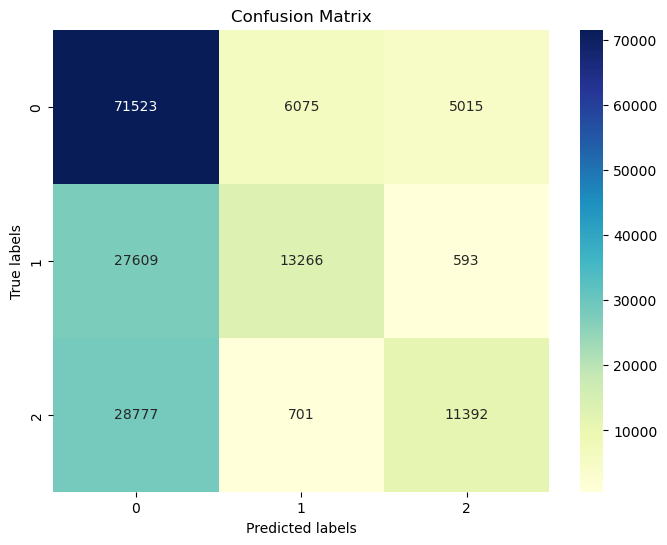

In [16]:
from sklearn.metrics import confusion_matrix
predictions_prob = simple_model.predict(X_sum_test)
predictions_labels = np.argmax(predictions_prob, axis=1)
y_test_labels = np.argmax(y_sum_test, axis=1)
cm = confusion_matrix(y_test_labels, predictions_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Signal Efficiency
signal_efficiency = cm[0, 0] / np.sum(cm[0, :])

# Background Rejection Rate
background_rejection = (cm[1, 1] + cm[1, 2]+cm[2, 1] + cm[2, 2]) / (np.sum(cm[1, :]) + np.sum(cm[2, :]))

print("Signal Efficiency:", signal_efficiency)
print("Background Rejection Rate:", background_rejection)

Signal Efficiency: 0.8657596262089502
Background Rejection Rate: 0.3151886127911778


In [18]:
from sklearn.metrics import roc_auc_score
class_1_true = y_sum_test[:, 0]
class_1_scores = predictions_prob[:, 0]

# Calculate the AUC for class 1
class_1_auc = roc_auc_score(class_1_true, class_1_scores)

print("Class 1 AUC:", class_1_auc)

Class 1 AUC: 0.621440826245857


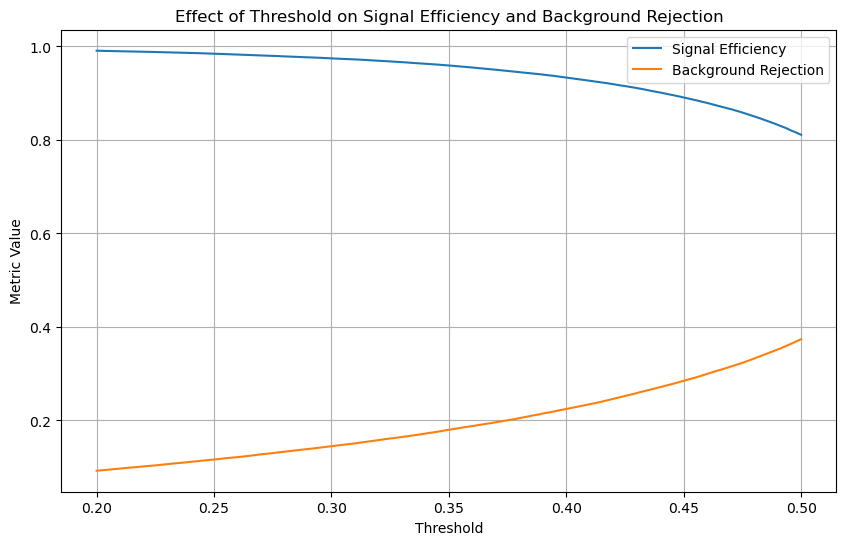

In [19]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0.2, 0.5, 500)
signal_efficiencies = []
background_rejections = []

for threshold in thresholds:
    # predicted_class = ((predictions_prob[:, 0] + threshold > predictions_prob[:, 1]) & (predictions_prob[:, 0] + threshold > predictions_prob[:, 2])).astype(int)
    predicted_class = (predictions_prob[:, 0] > threshold).astype(int)
    # Compute confusion matrix
    cm = confusion_matrix(y_sum_test[:, 0], predicted_class)
    
    # Calculate signal efficiency and background rejection
    signal_efficiency = cm[1, 1] / np.sum(cm[1, :])
    background_rejection = cm[0, 0] / np.sum(cm[0, :])
    
    # Store metrics
    signal_efficiencies.append(signal_efficiency)
    background_rejections.append(background_rejection)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, signal_efficiencies, label='Signal Efficiency')
plt.plot(thresholds, background_rejections, label='Background Rejection')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Effect of Threshold on Signal Efficiency and Background Rejection')
plt.legend()
plt.grid(True)
plt.show()

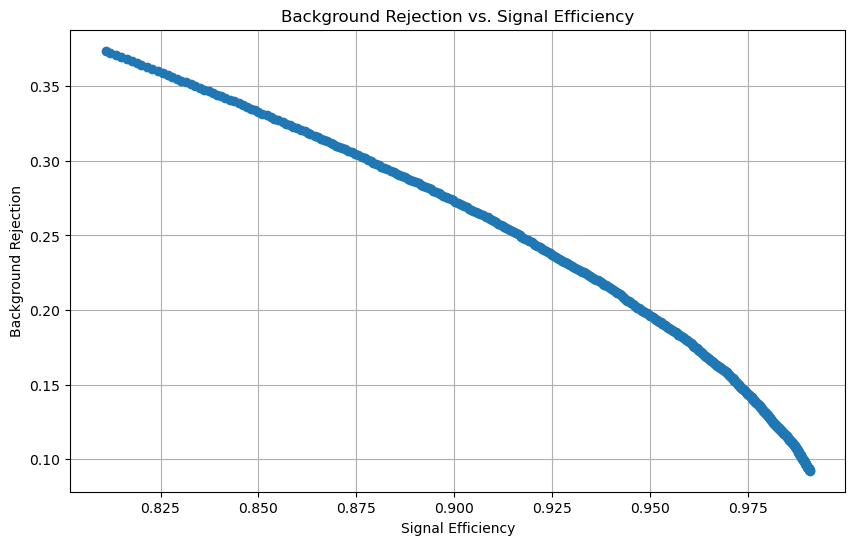

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(signal_efficiencies, background_rejections, marker='o')
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Background Rejection vs. Signal Efficiency')
plt.grid(True)
plt.show()

In [21]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_sum_test, predictions_prob)
print(f"AUC: {auc}")

AUC: 0.7157722348424933


In [22]:
def find_closest(sorted_array, value):
    # Ensure the array is a NumPy array
    sorted_array = np.array(sorted_array)

    # Compute the absolute difference
    abs_diff = np.abs(sorted_array - value)

    # Find the index of the minimum difference
    closest_index = np.argmin(abs_diff)

    return closest_index


index_848 = find_closest(signal_efficiencies, 0.848)
index_933 = find_closest(signal_efficiencies, 0.933)
index_976 = find_closest(signal_efficiencies, 0.976)
print(f"Signal Efficiency:{signal_efficiencies[index_848]*100:.1f}%",f"Background Rejections:{background_rejections[index_848]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_933]*100:.1f}%",f"Background Rejections:{background_rejections[index_933]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_976]*100:.1f}%",f"Background Rejections:{background_rejections[index_976]*100:.1f}%")

Signal Efficiency:84.8% Background Rejections:33.5%
Signal Efficiency:93.3% Background Rejections:22.5%
Signal Efficiency:97.6% Background Rejections:14.1%


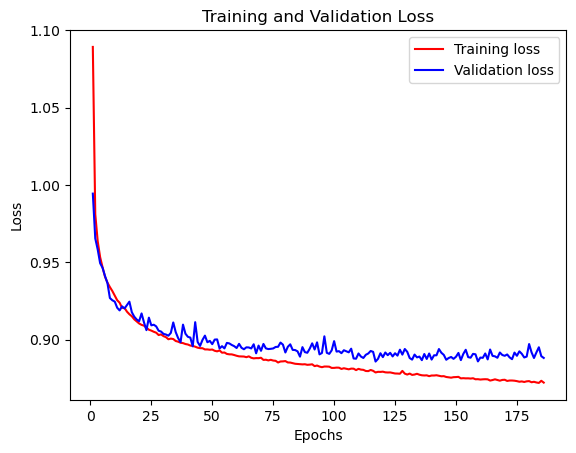

In [23]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss) + 1)
plt.figure()
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

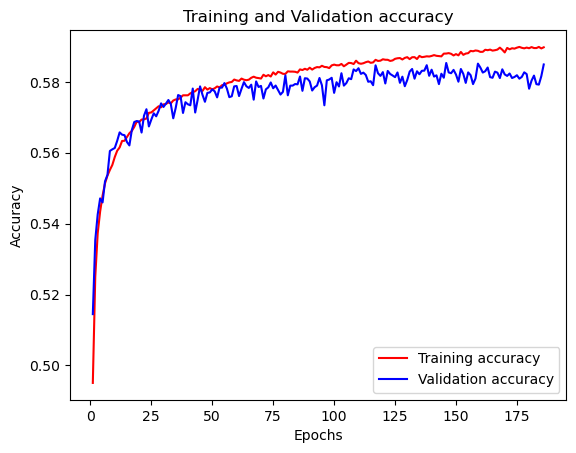

In [24]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_accuracy) + 1)
plt.figure()
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
print(np.sum(y_sum_train[:,0]))
print(y_sum_train.shape)
print(np.sum(y_sum_test[:,0]))
print(y_sum_test.shape)

384615.0
(769767, 3)
82613.0
(164951, 3)


In [26]:
# simple_model.save('simple_mode.h5')
# Dense_w0 = simple_model.layers[0].get_weights()[0].flatten(order='C')
# Dense_b0 = simple_model.layers[0].get_weights()[1].flatten(order='C')

# Dense_w1 = simple_model.layers[1].get_weights()[0].flatten(order='C')
# Dense_b1 = simple_model.layers[1].get_weights()[1].flatten(order='C')

# Dense_w2 = simple_model.layers[2].get_weights()[0].flatten(order='C')
# Dense_b2 = simple_model.layers[2].get_weights()[1].flatten(order='C')

In [27]:
# np.savetxt('simpleNN_Dense_w0_32.txt', Dense_w0)
# np.savetxt('simpleNN_Dense_b0_32.txt', Dense_b0)

# np.savetxt('simpleNN_Dense_w1_64.txt', Dense_w1)
# np.savetxt('simpleNN_Dense_b1_64.txt', Dense_b1)

# np.savetxt('simpleNN_Dense_w2_3.txt', Dense_w2)
# np.savetxt('simpleNN_Dense_b2_3.txt', Dense_b2)